### GNNS Final Project

In [2]:
!pip install kornia
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-o42mmmox
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-o42mmmox
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
from google.colab import drive
drive.mount('/content/drive')
checkpoint_path = '/content/drive/MyDrive/checkpoints/lambda_model.pth'
dataset_path = '/content/drive/MyDrive/dataset.pkl'
log_path = '/content/drive/MyDrive/logs/'
# Make sure the directory exists
#import os
#os.makedirs(checkpoint_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import clip
import numpy as np
from einops import rearrange, repeat
from transformers import CLIPTokenizer, CLIPTextModel
from transformers import AutoTokenizer, AutoModel
import kornia
import zipfile
import pickle
import torchvision.transforms as transforms
from PIL import Image
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

"""
    CLIP embedder classes adapted from https://github.com/UCSB-NLP-Chang/DiffusionDisentanglement/blob/main/ldm/modules/encoders/modules.py#L5
"""
class FrozenClipTextEmbedder(nn.Module):
    """
    Uses the CLIP transformer encoder for text.
    """
    def __init__(self, version='ViT-L/14', device=DEVICE, max_length=77, n_repeat=1, normalize=True):
        super().__init__()
        self.model, _ = clip.load(version, jit=False, device=DEVICE) #CLIPModel.from_pretrained(med_clip_model).to(DEVICE)#
        self.device = DEVICE
        self.max_length = max_length
        self.n_repeat = n_repeat
        self.normalize = normalize

    def freeze(self):
        self.model = self.model.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        tokens = clip.tokenize(text).to(self.device)
        z = self.model.encode_text(tokens)
        if self.normalize:
            z = z / torch.linalg.norm(z, dim=1, keepdim=True)
        return z

    def encode(self, text):
        z = self(text)
        if z.ndim==2:
            z = z[:, None, :]
        z = repeat(z, 'b 1 d -> b k d', k=self.n_repeat)
        return z

class FrozenClipImageEmbedder(nn.Module):
    """Uses the CLIP image encoder."""
    def __init__(self, model='ViT-L/14', device=DEVICE, antialias=False):
        super().__init__()
        self.model, _ = clip.load(model, device=DEVICE)
        self.device = DEVICE
        self.antialias = antialias
        self.register_buffer('mean', torch.Tensor([0.48145466, 0.4578275, 0.40821073]), persistent=False)
        self.register_buffer('std', torch.Tensor([0.26862954, 0.26130258, 0.27577711]), persistent=False)

    def forward(self, x):
        """Encodes the image into embeddings."""
        x = self.preprocess(x).to(self.device)
        return self.model.encode_image(x).to(self.device)

    def encode(self, x):
        """Encodes an image into CLIP embedding."""
        return self(x)

    def preprocess(self, x):
            """ Resize and normalize image for CLIP """
            if isinstance(x, np.ndarray):
                x = torch.tensor(x, dtype=torch.float32)  # Convert NumPy to Tensor
            if isinstance(x, Image.Image):
                x = transforms.ToTensor()(x)  # Converts to (3, H, W), normalized to [0,1]
            #print('ndims:', x.ndim, ' shape:' , x.shape)
            if x.ndim == 2:  # Grayscale images (H, W)
                x = x.unsqueeze(0)  # Add channel dimension → (1, H, W)
                x = x.repeat(3, 1, 1)  # Convert to 3 channels → (3, H, W)

            if x.shape[0] == 1:  # Convert grayscale to RGB by repeating channels
                x = x.repeat(3, 1, 1)  # Now shape is (3, H, W)

            x = x / 255.0  # Normalize pixel values to [0,1]

            # Make sure x is on the same device as self.mean
            x = x.to(self.mean.device)

            x = kornia.geometry.resize(x.unsqueeze(0), (224, 224),
                                        interpolation='bicubic', align_corners=True,
                                        antialias=self.antialias)  # Add batch dim

            # Move self.mean and self.std to the same device as x
            x = (x - self.mean.to(x.device)[:, None, None]) / self.std.to(x.device)[:, None, None]

            return x

"""
    CLIP embedder classes of the stable diffusion model itself
"""

class FrozenSDTextEmbedder(nn.Module):
    """
    Uses the CLIP transformer encoder for text.
    """
    def __init__(self, model, device=DEVICE, max_length=77, n_repeat=1, normalize=True):
        super().__init__()
        self.model = model.text_encoder #StableDiffusionPipeline.from_pretrained("Nihirc/Prompt2MedImage").text_encoder
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")  # Use CLIP tokenizer #self.tokenizer = CLIPTokenizer.from_pretrained("Nihirc/Prompt2MedImage")
        self.device = DEVICE
        self.max_length = max_length
        self.n_repeat = n_repeat
        self.normalize = normalize

    def freeze(self):
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, text):
        # Tokenize input text
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Move tokens to the correct device
        tokens = {k: v.to(self.device) for k, v in tokens.items()}

        # Make sure the model itself is also on the same device!
        self.model = self.model.to(self.device)

        # Pass through the text encoder
        with torch.no_grad():
            text_embeddings = self.model(input_ids=tokens["input_ids"])[0]  # No need to call `.to(self.device)` again

        # Normalize embeddings if needed
        if self.normalize:
            text_embeddings = text_embeddings / torch.linalg.norm(text_embeddings, dim=-1, keepdim=True)

        return text_embeddings

    def encode(self, text):
        text_embeddings = self.forward(text).to(self.device)
        if text_embeddings.ndim == 2:
            text_embeddings = text_embeddings[:, None, :]
        text_embeddings = text_embeddings.repeat(1, self.n_repeat, 1).to(self.device)
        return text_embeddings


class FrozenSDImageEmbedder(nn.Module):
    """Uses the CLIP image encoder."""
    def __init__(self, model, device=DEVICE, antialias=False):
        super().__init__()

        self.device = device
        self.antialias = antialias
        self.model = model

        # Access the VAE model from the pipeline and move to device
        self.vae = self.model.vae.to(self.device)  # Get the VAE model, move to device
        self.register_buffer('mean', torch.Tensor([0.5, 0.5, 0.5]), persistent=False)
        self.register_buffer('std', torch.Tensor([0.5, 0.5, 0.5]), persistent=False)

    def forward(self, x):
        """Encodes the image into embeddings using the diffusion model's image encoder."""
        x = self.preprocess(x).to(self.device)  # Ensure input is on the correct device
        with torch.no_grad():
            # Use VAE's encoding method to get latent representation
            encoded = self.vae.encode(x).latent_dist.sample()
            encoded = encoded * 0.18215  # Apply scaling factor for diffusion
        return encoded.to(self.device)  # Ensure output is on the correct device

    def preprocess(self, x):
        """Resize and normalize image for the diffusion model."""
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        if isinstance(x, Image.Image):
            x = transforms.ToTensor()(x)

        if x.ndim == 2:  # If grayscale, convert to 3-channel RGB
            x = x.unsqueeze(0).repeat(3, 1, 1)

        if x.shape[0] == 1:  # Single-channel grayscale
            x = x.repeat(3, 1, 1)

        x = x.unsqueeze(0)  # Add batch dimension

        # Resize to 224x224 (standard for many models)
        x = F.interpolate(x, size=(224, 224), mode='bicubic', align_corners=False)

        # Normalize to [-1, 1] for diffusion models
        x = (x - 0.5) / 0.5

        return x.to(self.device)  # Move to the correct device

"""
    Create text descriptions
"""
def summarize_labels(labels, max_items=1):
    """ Summarizes a long label list while keeping key findings. This is because there is a limit to the input of the CLIP text embedder

    TODO: review if this is the best approach to deal with long descriptions """

    key_conditions = labels[:max_items]  # Take first labels
    other_count = max(0, len(labels) - max_items)
    # maybe try simpler prompts with just one condition
    #if other_count > 0:
    #    return f"{', '.join(key_conditions)}, and {other_count} other findings"
    #else:
    return ", ".join(key_conditions)

def create_neutral_desc(sample):
    """Creates a neutral medical descriptor from a dataset entry
     sample: Shape [filename, img_array, orientation, labels] """
    filename, img_array, orientation, labels = sample

    # Convert label string to a proper list
    labels = eval(labels) if isinstance(labels, str) else labels
    # Join labels into a sentence
    label_text = summarize_labels(labels)  # Summarize findings
    if label_text == "normal":
        return f"A chest X-ray with no findings."
    if label_text == "unchanged":
        return f"A chest X-ray with unchanged findings."
    return f"A chest X-ray with {label_text}."

def create_style_rich_desc(sample):
    """
    Creates a style-rich descriptor with more context
    sample: Shape [filename, img_array, orientation, labels]
    """
    filename, img_array, orientation, labels = sample

    # Convert label string to a proper list
    labels = eval(labels) if isinstance(labels, str) else labels
    # Join labels into a sentence
    label_text = summarize_labels(labels)  # Summarize findings
    if label_text == "normal":
        return f"A chest X-ray with no findings taken in {orientation} orientation."
    if label_text == "unchanged":
        return f"A chest X-ray with unchanged findings, taken in {orientation} orientation."
    return f"A chest X-ray with {label_text}, taken in {orientation} orientation."

def load_data_add_descriptions(pickle_filename):
    """ Adds description strings to the dataset which are later turned into embeddings """
    with open(pickle_filename, "rb") as f:
        dataset = pickle.load(f)
        imgs_w_desc = list()
        for sample in dataset[:10]: #small subset to test training
            neutral = create_neutral_desc(sample)
            style_rich = create_style_rich_desc(sample)
            imgs_w_desc.append([sample[0], sample[1], neutral, style_rich]) #filename, img, neutral desc, syle rich desc

    for sample in imgs_w_desc[:10]:
        print(sample[0], sample[2], sample[3])
    print('num of samples: ', len(imgs_w_desc))
    return imgs_w_desc

"""
    Create embeddings
"""

def add_embeddings_single_img(imgs_w_desc, model=None):
    """ turn the description strings and images into embeddings
    imgs_w_desc: Shape [[filename, img_array, neutral_desc, style_rich_desc]]"""
    clip_image_embedder = FrozenClipImageEmbedder()
    clip_text_embedder = FrozenClipTextEmbedder()
    # Freeze models for inference
    clip_image_embedder.eval()
    clip_text_embedder.eval()

    embedded_data = []

    with torch.no_grad():  # No gradients needed
        for sample in imgs_w_desc:
            filename, img_array, neutral_desc, style_rich_desc = sample

            # Convert text to embeddings
            neutral_embedding = clip_text_embedder.encode([neutral_desc]).squeeze(1).to(DEVICE)  # Shape: (1, D) → (D,)
            style_embedding = clip_text_embedder.encode([style_rich_desc]).squeeze(1).to(DEVICE)

            # Convert image to embedding
            img_embedding = clip_image_embedder.forward(img_array).squeeze(0).to(DEVICE)
            # Store results
            embedded_data.append((filename, img_embedding, neutral_embedding, style_embedding))
    #print("Embeddings added; first sample: ", embedded_data[0])
    return embedded_data


def add_embeddings(imgs_w_desc, batch_size):
    """ turn the description strings and images into embeddings in batches
    imgs_w_desc: Shape [[filename, img_array, neutral_desc, style_rich_desc]]
    """
    clip_image_embedder = FrozenClipImageEmbedder()
    clip_text_embedder = FrozenClipTextEmbedder()

    # Freeze models for inference
    clip_image_embedder.eval()
    clip_text_embedder.eval()

    embedded_data = []

    with torch.no_grad():  # No gradients needed
        for i in range(0, len(imgs_w_desc), batch_size):
            batch_samples = imgs_w_desc[i:i + batch_size]
            filenames = [sample[0] for sample in batch_samples]
            images = [sample[1] for sample in batch_samples]
            neutral_descs = [sample[2] for sample in batch_samples]
            style_descs = [sample[3] for sample in batch_samples]

            # Process the batch
            neutral_embeddings =  []
            for neutral_desc in neutral_descs:
              #[print(neutral_desc)
              neutral_embedding = clip_text_embedder.encode(neutral_desc).to(DEVICE)
              neutral_embeddings.append(neutral_embedding)
            style_embeddings = []
            for style_desc in style_descs:
              #print(style_desc)
              style_embedding = clip_text_embedder.encode(style_desc).to(DEVICE)
              style_embeddings.append(style_embedding)
            img_embeddings = []
            for image in images:
              img_embedding = clip_image_embedder.forward(image).squeeze(0).to(DEVICE)
              img_embeddings.append(img_embedding)
            for idx, sample in enumerate(batch_samples):
              #print(sample)
              #print(len(img_embeddings), len(neutral_embeddings), len(style_embeddings))
              embedded_data.append([filenames[idx], img_embeddings[idx], neutral_embeddings[idx], style_embeddings[idx]])
              #print(embedded_data[idx])

    return embedded_data


"""
    Soft combination of embeddings according to Disentanglement paper (Wu et al., 2022)
"""
def soft_combine_embeddings(c0, c1, lambda_t):
    """
    c0 (Tensor) The neutral text embedding. Shape: [batch, dim]
    c1 (Tensor): The style-rich text embedding. Shape: [batch, dim]
    lambda_t (Tensor): The combination weight (0 to 1). Shape: [T] or [T, 1]

    c_t (Tensor): The combined embedding over time. Shape: [T, batch, dim]
    """
    # Ensure lambda_t has correct shape for broadcasting
    lambda_t = lambda_t.reshape(-1, 1, 1)._requires_grad()  # Safe way to reshape without breaking the computation graph

    # Linearly combine the embeddings over time
    c_t = lambda_t * c1 + (1 - lambda_t) * c0  # Shape: [T, batch, dim]

    return c_t, lambda_t

def get_lambda_schedule(T, mode="linear"):
    """
    Generates a lambda schedule over T timesteps
    """
    if mode == "linear":
        return torch.linspace(0, 1, steps=T)  # Linearly increasing
    elif mode == "sigmoid":
        x = torch.linspace(-6, 6, steps=T)  # Sigmoid range
        return torch.sigmoid(x)  # Smooth start and end
    elif mode == "cosine":
        return (1 - torch.cos(torch.linspace(0, 3.1416, steps=T))) / 2  # Cosine ease-in-out
    else:
        raise ValueError("Invalid mode! Choose 'linear', 'sigmoid', or 'cosine'.")


def test_soft_combined_embeddings(embedded_data_list, T=50):
    """
    embedded_data_list: Shape [[filename, img_embedding, neutral_desc_embedding, style_rich_desc_embedding]]
    """
    for sample in embedded_data_list:
        lambda_t = get_lambda_schedule(T, mode="sigmoid")  # TODO: Try different schedules!

        # Compute the soft combination of embeddings
        c_t, _ = soft_combine_embeddings(sample[2], sample[3], lambda_t)
        #print(c_t)


In [ ]:
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def compute_losses(img_neutral, img_interpolated, img_stylized, text_neutral_emb, text_stylized_emb):
    """
    Computes CLIP loss + perceptual loss for disentanglement training.
    """
    # this loss makes no sense because we only have one image

    # Define transformation
    to_tensor = transforms.ToTensor()

    # Convert images to tensors if they are not already
    if not isinstance(img_neutral, torch.Tensor):
        img_neutral = to_tensor(img_neutral).to(DEVICE)

    if not isinstance(img_interpolated, torch.Tensor):
        img_interpolated = to_tensor(img_interpolated).to(DEVICE)

    if not isinstance(img_stylized, torch.Tensor):
        img_stylized = to_tensor(img_stylized).to(DEVICE)

    # Compute CLIP loss
    def clip_loss(img_emb_neutral, img_emb_interpolated, img_emb_stylized, text_neutral_emb, text_stylized_emb):
        direction_text = text_stylized_emb - text_neutral_emb
        direction_image = img_emb_stylized - img_emb_interpolated
        return -F.cosine_similarity(direction_text, direction_image, dim=-1).mean()

    # Compute perceptual loss (ensuring Xₜ remains semantically close to X₀)
    def perceptual_loss(img_neutral, img_interpolated):
        return F.l1_loss(img_neutral, img_interpolated)

    beta = 0.5  # Adjust as needed
    loss = clip_loss(img_neutral, img_interpolated, img_stylized, text_neutral_emb, text_stylized_emb) + beta * perceptual_loss(img_neutral, img_interpolated)

    return loss

def clip_loss(img_emb_interpolated, text_neutral_emb, text_stylized_emb, alpha=0.8):
    sim_neutral = F.cosine_similarity(img_emb_interpolated, text_neutral_emb, dim=-1)
    sim_stylized = F.cosine_similarity(img_emb_interpolated, text_stylized_emb, dim=-1)

    # Encourage similarity to both, but prioritize stylized alignment
    return -((1 - alpha) * sim_neutral.mean() + alpha * sim_stylized.mean())


def clip_loss_alternative_old(desc_neutral, desc_stylized, lambda_t, T, num_inference_steps, pipe, clip_image_embedder, weight=0.8):
  # Step 1: Soft combine embeddings using lambda_t
    print(f"lambda_t grad_fn before soft combine before pipe: {lambda_t.grad_fn}")

    #lambda_t = lambda_t.view(-1, 1, 1).requires_grad_()    # Safe way to reshape without breaking the computation graph
    c_t, lambda_t = soft_combine_embeddings(lambda_t=lambda_t, c0=desc_neutral, c1=desc_stylized) #lambda_t * desc_stylized + (1 - lambda_t) * desc_neutral  # Shape: [T, batch, dim]
    total_loss = 0
    print(f"lambda_t grad_fn after soft combine embeddings but before pipe: {lambda_t.grad_fn}")

    # Step 2: Generate images and calculate loss for each diffusion step
    for t in range(T):
        empty_negative_prompt = torch.zeros_like(c_t[t]).to(DEVICE)

        output = pipe(prompt_embeds=c_t[t].unsqueeze(0), negative_prompt_embeds=empty_negative_prompt.unsqueeze(0), num_inference_steps=num_inference_steps)
        print(f"c_t grad_fn: {c_t.grad_fn}")
        # use intermediate embeddings instead?
        if hasattr(output, 'latent_embeds'):  
            img_emb = output.latent_embeds[0]
        else:
            img_emb = output.images[0]
        
        # Step 3: Calculate the cosine similarity loss for each step
        print("Before clip embedder forward: lambda_t.requires_grad =", lambda_t.requires_grad) #
        print(f"lambda_t grad_fn: {lambda_t.grad_fn}")
        img_interpolated = clip_image_embedder.forward(img_emb).squeeze(0).to(DEVICE)
        print("After clip embedder forward: lambda_t.requires_grad =", lambda_t.requires_grad) #
        print("After clip embedder forward: img_interplolated.requires_grad =", img_interpolated.requires_grad) #
        print(f"img_interpolated grad_fn: {img_interpolated.grad_fn}")
        print(f"lambda_t grad_fn: {lambda_t.grad_fn}")


        similarity_loss = F.cosine_similarity(img_interpolated, desc_neutral)
        style_loss = F.cosine_similarity(img_interpolated, desc_stylized)
        
        # Sum the similarity and style loss
        step_loss = similarity_loss + style_loss
        
        # Optionally weight the loss if needed (e.g., higher weight for later steps)
        total_loss += weight * step_loss
        lambda_penalty = 0.01 * torch.sum(lambda_t ** 2)  # L2 regularization on lambda_t
        total_loss = total_loss + lambda_penalty

        print(f"end of loss function lambda_t grad_fn: {lambda_t.grad_fn}")
    return total_loss, lambda_t

def clip_loss_alternative(desc_neutral, desc_stylized, lambda_t, T, num_inference_steps, pipe, clip_image_embedder, weight=0.8):
    print(f"lambda_t grad_fn before soft combine before pipe: {lambda_t.grad_fn}")

    # Combine embeddings
    c_t, lambda_t = soft_combine_embeddings(lambda_t=lambda_t, c0=desc_neutral, c1=desc_stylized)

    print(f"lambda_t grad_fn after soft combine embeddings but before pipe: {lambda_t.grad_fn}")

    step_losses = []  # Store each step's loss

    # Loop over diffusion steps
    for t in range(T):
        empty_negative_prompt = torch.zeros_like(c_t[t]).to(DEVICE)

        output = pipe(
            prompt_embeds=c_t[t].unsqueeze(0),
            negative_prompt_embeds=empty_negative_prompt.unsqueeze(0),
            num_inference_steps=num_inference_steps
        )

        print(f"c_t grad_fn: {c_t.grad_fn}")

        if hasattr(output, 'latent_embeds'):  
            img_emb = output.latent_embeds[0]
        else:
            img_emb = output.images[0]
        
        print("Before clip embedder forward: lambda_t.requires_grad =", lambda_t.requires_grad)
        print(f"lambda_t grad_fn: {lambda_t.grad_fn}")

        img_interpolated = clip_image_embedder.forward(img_emb).squeeze(0).to(DEVICE)

        print("After clip embedder forward: lambda_t.requires_grad =", lambda_t.requires_grad)
        print("After clip embedder forward: img_interpolated.requires_grad =", img_interpolated.requires_grad)
        print(f"img_interpolated grad_fn: {img_interpolated.grad_fn}")
        print(f"lambda_t grad_fn: {lambda_t.grad_fn}")

        # Compute individual losses
        similarity_loss = F.cosine_similarity(img_interpolated, desc_neutral)
        style_loss = F.cosine_similarity(img_interpolated, desc_stylized)
        
        step_loss = similarity_loss + style_loss

        # Apply weight and store loss
        weighted_loss = weight * step_loss
        step_losses.append(weighted_loss)

    # Sum all step losses **after** the loop
    total_loss = torch.sum(torch.stack(step_losses))

    # Add regularization term for lambda_t
    lambda_penalty = 0.01 * torch.sum(lambda_t ** 2)
    total_loss = total_loss + lambda_penalty
    print(f"end of loss function lambda_t grad_fn: {lambda_t.grad_fn}")

    return total_loss, lambda_t


In [ ]:
import sys
import os
from diffusers import StableDiffusionPipeline
import torch
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Disable NSFW checker in pipeline since some of the chest xrays are accidentally flagged which returns a black image
def dummy_checker(images, **kwargs):
    return images, [False] * len(images)# Always return images without flagging them

def generate_images_from_embeddings_visualize(embedded_data_list, lambda_t, pipe, T=20, num_inference_steps=50):
    """
    Generates and visualizes images using soft-combined embeddings across denoising steps.
    embedded_data_list: [[filename, img_embedding, neutral_desc_embedding, style_rich_desc_embedding]]
    """

    # Load the pre-trained diffusion model
    pipe = pipe.to(DEVICE) #StableDiffusionPipeline.from_pretrained(model_id).to(DEVICE)
    pipe.safety_checker = dummy_checker

    all_generated_images = {}  # Store images per sample
    for sample in embedded_data_list:
        filename = sample[0]  # Get filename for reference
        c_t, lambda_t = soft_combine_embeddings(sample[2], sample[3], lambda_t).to(DEVICE)  # Soft combination

        generated_images = []  # Store images for this sample

        for t in range(T):  # Simulating diffusion steps
                empty_negative_prompt = torch.zeros_like(c_t[t]).to(DEVICE) # dummy because pipeline expects 2 embeddings

                img = pipe(prompt_embeds=c_t[t].unsqueeze(0), negative_prompt_embeds=empty_negative_prompt.unsqueeze(0), num_inference_steps=num_inference_steps).images[0]
                generated_images.append(img)  # Store generated image

        all_generated_images[filename] = generated_images  # Store all images

        # Visualizing the generated images
        plt.figure(figsize=(10, 2))
        for i in range(min(5, T)):  # Show up to 5 images for preview
            plt.subplot(1, 5, i + 1)
            plt.imshow(generated_images[i])
            plt.axis("off")
        plt.suptitle(f"Generated Images for {filename}")
        plt.show()

    return all_generated_images  # Return all images for further processing


def generate_images_from_embeddings(embedded_data_list, T, lambda_t, num_inference_steps, pipe):
    """
    Generates images using soft-combined embeddings across denoising steps.
    embedded_data_list: [[filename, img_embedding, neutral_desc_embedding, style_rich_desc_embedding]]
    """

    # Load the pre-trained diffusion model
    pipe = pipe.to(DEVICE) #StableDiffusionPipeline.from_pretrained(model_id).to(DEVICE)
    pipe.safety_checker = dummy_checker

    all_generated_images = {}  # Store images per sample
    for sample in embedded_data_list:
        filename = sample[0]  # Get filename for reference
        print("generate images: processing file ", filename)
        c_t, lambda_t = soft_combine_embeddings(sample[2], sample[3], lambda_t).to(DEVICE)  # Soft combination

        generated_images = []  # Store images for this sample

        for t in range(T):  # Simulating diffusion steps
                empty_negative_prompt = torch.zeros_like(c_t[t]).to(DEVICE) # dummy because pipeline expects 2 embeddings
                #img = pipe(prompt_embeds=c_t[t].unsqueeze(0), negative_prompt_embeds=empty_negative_prompt.unsqueeze(0), num_inference_steps=num_inference_steps)#.images[0]
                output = pipe(prompt_embeds=c_t[t].unsqueeze(0), negative_prompt_embeds=empty_negative_prompt.unsqueeze(0), num_inference_steps=num_inference_steps)
                if hasattr(output, 'latent_embeds'):  # Check if embeddings are available!
                    img_emb = output.latent_embeds[0]
                else:
                    img_emb = output.images[0]  # Fallback to image
                generated_images.append(img_emb)  # Store generated image

        all_generated_images[filename] = generated_images  # Store all images
        print("end of generate function: lambda_t.requires_grad =", lambda_t.requires_grad) 
        all_generated_images[filename] = generated_images  # Store all images

        return generated_images  # Return list of images across diffusion steps

def plot_losses(train_losses, test_losses):
    """
    Plots training and testing loss curves over epochs.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o', color='b')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker='s', color='r')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Testing Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def train_lambda_train_test(embedded_data_list, T, save_path, lambda_t, num_inference_steps, pipe, loaded_optimizer=None, epochs=10, lr=1e-3, batch_size=8):
    """
    Optimizes lambda_t using train/test split and batches.
    """
    # Logging setup
    import csv
    import os

    log_file = log_path+"training_log.csv"
    lambda_log_file = log_path+"lambda_log.csv"
    lambda_values = lambda_t.detach().cpu().numpy().tolist()  # Convert tensor to list

    # Create or overwrite lambda log file
    if not os.path.exists(lambda_log_file):
      with open(lambda_log_file, mode="w", newline="") as file:
          writer = csv.writer(file)
          header = [f"Lambda_{t+1}" for t in range(T)]  # Column names
          writer.writerow(header)

    # Append first lambda to CSV
    #with open(lambda_log_file, mode="a", newline="") as file:
    #      writer = csv.writer(file)
    #      writer.writerow(lambda_values)  # Write λ values

    # Check if the file exists, if not create it with headers
    if not os.path.exists(log_file):
        with open(log_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Lambda", "Train Loss", "Test Loss"])


    # Split data into training and testing sets
    clip_image_embedder = FrozenClipImageEmbedder()

    # Optimizer
    if loaded_optimizer is None:
      optimizer = torch.optim.Adam([lambda_t], lr=lr)
    else:
      optimizer = loaded_optimizer
      print("loaded optimizer checkpoint")

    # Store losses for plotting
    train_losses = []
    test_losses = []
    print("Start training loop")

    # Split the embedded data into train and test sets
    num_samples = len(embedded_data_list)
    train_size = int(0.8 * num_samples)  # 80% for training
    test_size = num_samples - train_size  # 20% for testing

    # Split the embedded data into train and test sets
    train_data = embedded_data_list[:train_size]
    test_data = embedded_data_list[train_size:]

    # Define a transformation to convert PIL image -> Tensor
    transform = transforms.Compose([
         transforms.ToTensor(),  # Converts PIL image to tensor
          transforms.Resize((224, 224)),  # Resize to CLIP input size
          transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
            ])
    # Train loop with batch processing
    for epoch in range(epochs):
        total_train_loss = 0
        total_test_loss = 0

        # Batching for training
        for i in range(0, len(train_data), batch_size):
            batch_samples = train_data[i:i + batch_size]
            filenames = [sample[0] for sample in batch_samples]
            neutral_desc_embeddings = [sample[2] for sample in batch_samples]
            stylized_desc_embeddings = [sample[3] for sample in batch_samples]

            # Generate images for each sample in the batch (individual call to generate_images_from_embeddings)
            generated_images = []
            print("Train: generate images")
            for sample in batch_samples:
                generated_images_for_sample = generate_images_from_embeddings([sample], T=T, lambda_t=lambda_t, num_inference_steps=num_inference_steps, pipe=pipe)
                img_interpolated = generated_images_for_sample[-1]
                img_interpolated = transform(img_interpolated).to(DEVICE)

                generated_images.append(img_interpolated)

            # Calculate loss for the batch
            batch_loss = 0
            print("Train: calculate loss")
            for idx, sample in enumerate(batch_samples):
                img_interpolated = generated_images[idx]
                desc_neutral, desc_stylized = sample[2], sample[3]

                #img_interpolated = transforms.ToTensor()(img_interpolated).to_device(DEVICE)#unsqueeze(0).to(DEVICE)
                img_interpolated = clip_image_embedder.forward(img_interpolated).squeeze(0).to(DEVICE)

                # Compute loss for this sample
                loss = clip_loss(img_interpolated, desc_neutral, desc_stylized)
                batch_loss += loss

            # Backpropagate
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            total_train_loss += batch_loss.item()

        # Testing loop (Batch processing for testing)
        for i in range(0, len(test_data), batch_size):
            batch_samples = test_data[i:i + batch_size]
            filenames = [sample[0] for sample in batch_samples]
            neutral_desc_embeddings = [sample[2] for sample in batch_samples]
            stylized_desc_embeddings = [sample[3] for sample in batch_samples]

            # Generate images for each sample in the batch (individual call to generate_images_from_embeddings)
            generated_images = []
            print("Test: generate images")
            for sample in batch_samples:
                # Generate images for each sample as done previously 
                generated_images_for_sample = generate_images_from_embeddings([sample], T=T, lambda_t=lambda_t, num_inference_steps=num_inference_steps, pipe=pipe)
                img_interpolated = generated_images_for_sample[-1]
                img_interpolated = transform(img_interpolated).to(DEVICE)
                generated_images.append(img_interpolated)

            # Calculate loss for the batch
            batch_loss = 0
            print("Test: calculate loss")
            for idx, sample in enumerate(batch_samples):
                img_interpolated = generated_images[idx]
                desc_neutral, desc_stylized = sample[2], sample[3]

                #img_interpolated = transforms.ToTensor()(img_interpolated).to(DEVICE)#unsqueeze(0).to(DEVICE)
                img_interpolated = clip_image_embedder.forward(img_interpolated).squeeze(0).to(DEVICE)

                # Compute loss for this sample
                loss = clip_loss(img_interpolated, desc_neutral, desc_stylized)
                batch_loss += loss.item()

            total_test_loss += batch_loss

        # Print training and testing losses
        avg_train_loss = total_train_loss / len(train_data)
        avg_test_loss = total_test_loss / len(test_data)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        # Store average losses per epoch
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        # Save model and losses
        save_dict = {
            "lambda_t": lambda_t.detach().cpu(),  # Move to CPU before saving
            "optimizer_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": test_losses
        }
        torch.save(save_dict, save_path)
        print(f"Model saved at: {save_path}")

        # Open in append mode and log data
        with open(log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([lambda_t.mean().item(), avg_train_loss, avg_test_loss])  # Logging the mean of lambda_t

        lambda_values = lambda_t.detach().cpu().numpy().tolist()  # Convert tensor to list

        # Append lambda to CSV
        with open(lambda_log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(lambda_values)  # Write λ values
            print(f"Epoch logged to {log_file} and {lambda_log_file}.")

    plot_losses(train_losses, test_losses)

    return lambda_t, train_losses, test_losses


def load_lambda_model(load_path=checkpoint_path):
    """
    Loads the saved lambda model.
    """
    if not os.path.exists(load_path):
        print(f"No saved model found at {load_path}!")
        return None, None

    checkpoint = torch.load(load_path, map_location=DEVICE)

    # Ensure lambda is restored as a trainable parameter
    lambda_t = torch.nn.Parameter(checkpoint["lambda_t"].to(DEVICE), requires_grad=True)

    optimizer = torch.optim.Adam([lambda_t])  # Recreate optimizer
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    print(f"Model loaded from: {load_path}")

    return lambda_t, optimizer



In [ ]:
# Disable NSFW checker in pipeline since some of the chest xrays are accidentally flagged which returns a black image
def dummy_checker(images, **kwargs):
    return images, [False] * len(images)# Always return images without flagging them

""" an alternative traiing function that uses clip_loss_alternative for loss computation """
def train_lambda_train_test_alternative(embedded_data_list, T, save_path, lambda_t, num_inference_steps, pipe, loaded_optimizer=None, epochs=10, lr=1e-3, batch_size=8):
    """
    Optimizes lambda_t using train/test split and batches.
    So... for context, I realized the old training function runs but never actually updates the lambda_t despite it being an nn.Parameter and part of the optimizer. Somewhere along the way
    the gradients seemed to get lost in the computation graph. So that's why here I've re-written the loss function, made changes to the way the pipe() function is called and tracked the
    grads of all the variables to make sure everyone has a grad_fn(c_t grad_fn: <AddBackward0 object at 0x7d03e8dee020>, img_interpolated grad_fn: <SqueezeBackward1 object at 0x7d03e8ded840>,
    lambda_t grad_fn: <ViewBackward0 object at 0x7d03e8ded840>).  Still, at the end of the loss where backward() is called lambda seems to have no gradients. 
    """
    # Logging setup
    import csv
    import os

    log_file = log_path+"training_log.csv"
    lambda_log_file = log_path+"lambda_log.csv"

    # Create or overwrite lambda log file
    if not os.path.exists(lambda_log_file):
      with open(lambda_log_file, mode="w", newline="") as file:
          writer = csv.writer(file)
          header = [f"Lambda_{t+1}" for t in range(T)]  # Column names
          writer.writerow(header)

    # Append first lambda to CSV
    #with open(lambda_log_file, mode="a", newline="") as file:
    #      writer = csv.writer(file)
    #      writer.writerow(lambda_values)  # Write λ values

    # Check if the file exists, if not create it with headers
    if not os.path.exists(log_file):
        with open(log_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Lambda", "Train Loss", "Test Loss"])

    print("Is lambda_t a Parameter?", isinstance(lambda_t, torch.nn.Parameter))

    # Split data into training and testing sets
    clip_image_embedder = FrozenClipImageEmbedder()

    # Optimizer
    if loaded_optimizer is None:
      optimizer = torch.optim.Adam([lambda_t], lr=lr)
    else:
      optimizer = loaded_optimizer
      print("loaded optimizer checkpoint")

    print("Lambda_t in optimizer:", any(p is lambda_t for p in optimizer.param_groups[0]['params']))
    for group in optimizer.param_groups:
        for p in group['params']:
            print(f"Optimizer param: {p.shape}, requires_grad={p.requires_grad}")
    # Store losses for plotting
    train_losses = []
    test_losses = []
    print("Start training loop")

    # Split the embedded data into train and test sets
    num_samples = len(embedded_data_list)
    train_size = int(0.8 * num_samples)  # 80% for training
    test_size = num_samples - train_size  # 20% for testing

    # Split the embedded data into train and test sets
    train_data = embedded_data_list[:train_size]
    test_data = embedded_data_list[train_size:]

    # Define a transformation to convert PIL image -> Tensor
    transform = transforms.Compose([
         transforms.ToTensor(),  # Converts PIL image to tensor
          transforms.Resize((224, 224)),  # Resize to CLIP input size
          transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
            ])
    
    pipe.safety_checker = dummy_checker # prevent imgs from being flagged as NSFW

    # Train loop with batch processing
    for epoch in range(epochs):
        total_train_loss = 0
        total_test_loss = 0
        # Batching for training
        for i in range(0, len(train_data), batch_size):
            batch_samples = train_data[i:i + batch_size]
            filenames = [sample[0] for sample in batch_samples]
            neutral_desc_embeddings = [sample[2] for sample in batch_samples]
            stylized_desc_embeddings = [sample[3] for sample in batch_samples]
            # Calculate loss for the batch
            batch_loss = 0
            print("Train: calculate loss")
            for idx, sample in enumerate(batch_samples):
                desc_neutral, desc_stylized = sample[2].requires_grad_(), sample[3].requires_grad_()
                original_lambda_shape = lambda_t.shape
                total_loss, lambda_t = clip_loss_alternative(desc_neutral, desc_stylized, lambda_t, T, num_inference_steps, pipe, clip_image_embedder, weight=0.8)
                print(f"back in training func lambda_t grad_fn: {lambda_t.grad_fn}")
                lambda_t.reshape(original_lambda_shape)
                lambda_t.retain_grad()
                print(f"back in training func after reshape lambda_t grad_fn: {lambda_t.grad_fn}")


                batch_loss = batch_loss + total_loss
                print(f"batch_loss.requires_grad = {batch_loss.requires_grad}")
                print("batch_loss grad_fn:", batch_loss.grad_fn)
                print(f"total_loss.requires_grad = {total_loss.requires_grad}")
                print("batch_loss grad_fn:", total_loss.grad_fn)
                    
            lambda_t.retain_grad()  # Ensure that gradients are retained for lambda_t
            # Backpropagate
            print(f"batch_loss.requires_grad = {batch_loss.requires_grad}")
            print("batch_loss grad_fn:", batch_loss.grad_fn)
            print("before backward lambda_t dtype:", lambda_t.dtype)                
            print(f"before backward lambda_t grad_fn: {lambda_t.grad_fn}")

            print("before backward lambda_t gradients:", lambda_t.grad)
                      
            optimizer.zero_grad()
            for p in optimizer.param_groups[0]['params']:
                print(f"{p.shape}: {p.grad}")
            batch_loss.backward(retain_graph=True)  # Retain the graph for further backward passes if needed
            print(f"Batch_loss gradient: {batch_loss.grad}")
            print("After backward lambda_t gradients:", lambda_t.grad)

            optimizer.step()

            total_train_loss += batch_loss.item()


        # Testing loop (Batch processing for testing)
        for i in range(0, len(test_data), batch_size):
            batch_samples = test_data[i:i + batch_size]
            filenames = [sample[0] for sample in batch_samples]
            neutral_desc_embeddings = [sample[2] for sample in batch_samples]
            stylized_desc_embeddings = [sample[3] for sample in batch_samples]

            # Calculate loss for the batch
            batch_loss = 0
            print("Test: calculate loss")
            for idx, sample in enumerate(batch_samples):
                desc_neutral, desc_stylized = sample[2], sample[3]

                total_loss, lambda_t = clip_loss_alternative(desc_neutral, desc_stylized, lambda_t, T, num_inference_steps, pipe, clip_image_embedder, weight=0.8)

                batch_loss += total_loss.item()

            total_test_loss += batch_loss

        # Print training and testing losses
        avg_train_loss = total_train_loss / len(train_data)
        avg_test_loss = total_test_loss / len(test_data)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        # Store average losses per epoch
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        # Save model and losses
        save_dict = {
            "lambda_t": lambda_t.detach().cpu(),  # Move to CPU before saving
            "optimizer_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": test_losses
        }
        torch.save(save_dict, save_path)
        print(f"Model saved at: {save_path}")

        # Open in append mode and log data
        with open(log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([lambda_t.mean().item(), avg_train_loss, avg_test_loss])  # Logging the mean of lambda_t

        lambda_values = lambda_t.detach().cpu().numpy().tolist()  # Convert tensor to list

        # Append lambda to CSV
        with open(lambda_log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(lambda_values)  # Write λ values
            print(f"Epoch logged to {log_file} and {lambda_log_file}.")

    plot_losses(train_losses, test_losses)

    return lambda_t, train_losses, test_losses

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

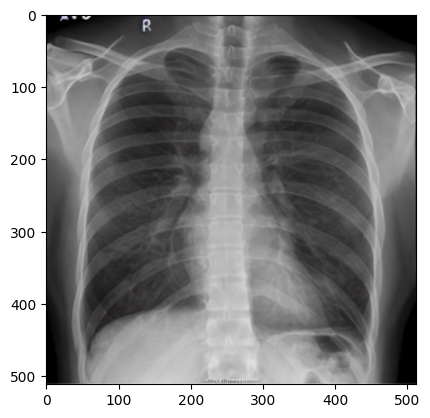

In [ ]:
# test the model with a prompt from our data
model_id = "Nihirc/Prompt2MedImage"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(DEVICE)

prompt = "A chest X-ray with alveolar pattern."
image_1 = pipe(prompt).images[0]
plt.imshow(image_1)

  0%|          | 0/50 [00:00<?, ?it/s]

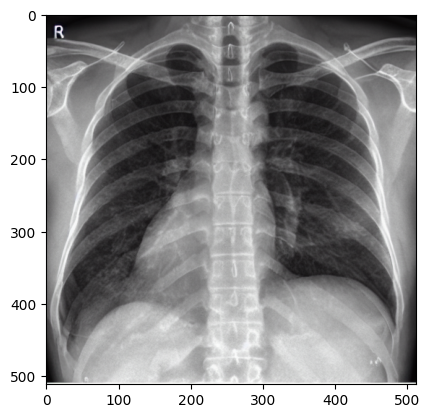

In [ ]:
prompt = "A chest X-ray with alveolar pattern, taken in L orientation."
image_2 = pipe(prompt).images[0]
plt.imshow(image_2)

In [ ]:
# visualize images from pretrained model with different lambda schedules
pickle_filename = 'dataset_small.pkl' #'/drive/MyDrive/dataset.pkl'
model = StableDiffusionPipeline.from_pretrained("Nihirc/Prompt2MedImage")
data_with_desc = load_data_add_descriptions(pickle_filename)
data_w_embeddings = add_embeddings_single_img(data_with_desc, model=model)
print("Lambda schedule: linear")
lambda_t = get_lambda_schedule(T=20, mode="linear").to(DEVICE)
generate_images_from_embeddings_visualize(embedded_data_list=data_w_embeddings[:3],  lambda_t=lambda_t, num_inference_steps=50, pipe=model)
print("Lambda schedule: sigmoid")
lambda_t = get_lambda_schedule(T=20, mode="sigmoid").to(DEVICE)
generate_images_from_embeddings_visualize(embedded_data_list=data_w_embeddings[:3], lambda_t=lambda_t, num_inference_steps=50, pipe=model)
print("Lambda schedule: cosine")
lambda_t = get_lambda_schedule(T=20, mode="cosine").to(DEVICE)
generate_images_from_embeddings_visualize(embedded_data_list=data_w_embeddings[:3], lambda_t=lambda_t, num_inference_steps=50, pipe=model)

In [ ]:
#pickle_filename = 'dataset_small.pkl'
model = StableDiffusionPipeline.from_pretrained("Nihirc/Prompt2MedImage")
batch_size = 2
num_inference_steps = 20
data_with_desc = load_data_add_descriptions(dataset_path)
data_w_embeddings = add_embeddings(data_with_desc, batch_size=batch_size)
T=20
#generate_images_from_embeddings_visualize(data_w_embeddings)
T = 20
lambda_t = torch.nn.Parameter(get_lambda_schedule(T=T, mode="sigmoid").to(DEVICE), requires_grad=True)
train_lambda_train_test(
    data_w_embeddings,
    T,
    lambda_t=lambda_t,
    batch_size=batch_size,
    num_inference_steps=num_inference_steps,
    save_path=checkpoint_path,
    pipe=model
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

20536686640136348236148679891455886468_k6ga29.png A chest X-ray with no findings. A chest X-ray with no findings taken in PA orientation.
135803415504923515076821959678074435083_fzis7d.png A chest X-ray with pulmonary fibrosis. A chest X-ray with pulmonary fibrosis, taken in L orientation.
135803415504923515076821959678074435083_fzis7b.png A chest X-ray with pulmonary fibrosis. A chest X-ray with pulmonary fibrosis, taken in PA orientation.
113855343774216031107737439268243531979_3k951l.png A chest X-ray with chronic changes. A chest X-ray with chronic changes, taken in PA orientation.
113855343774216031107737439268243531979_3k951n.png A chest X-ray with chronic changes. A chest X-ray with chronic changes, taken in L orientation.
313903302629300007485735352869488750471_75sg0k.png A chest X-ray with unchanged findings. A chest X-ray with unchanged findings, taken in AP orientation.
3137231742710829928-247610802266403640553_km0qf9.png A chest X-ray with laminar atelectasis. A chest X-ray

In [7]:
# retrain/continue training
model = StableDiffusionPipeline.from_pretrained("Nihirc/Prompt2MedImage")
batch_size = 4
num_inference_steps = 20
data_with_desc = load_data_add_descriptions(dataset_path)
data_w_embeddings = add_embeddings(data_with_desc, batch_size=batch_size)
T=20
loaded_lambda_t, optimizer = load_lambda_model(load_path=checkpoint_path)

train_lambda_train_test(
    data_w_embeddings,
    T,
    lambda_t=loaded_lambda_t,
    loaded_optimizer=optimizer,
    batch_size=batch_size,
    num_inference_steps=num_inference_steps,
    save_path=checkpoint_path,
    pipe=model
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

20536686640136348236148679891455886468_k6ga29.png A chest X-ray with no findings. A chest X-ray with no findings taken in PA orientation.
135803415504923515076821959678074435083_fzis7d.png A chest X-ray with pulmonary fibrosis. A chest X-ray with pulmonary fibrosis, taken in L orientation.
135803415504923515076821959678074435083_fzis7b.png A chest X-ray with pulmonary fibrosis. A chest X-ray with pulmonary fibrosis, taken in PA orientation.
113855343774216031107737439268243531979_3k951l.png A chest X-ray with chronic changes. A chest X-ray with chronic changes, taken in PA orientation.
113855343774216031107737439268243531979_3k951n.png A chest X-ray with chronic changes. A chest X-ray with chronic changes, taken in L orientation.
313903302629300007485735352869488750471_75sg0k.png A chest X-ray with unchanged findings. A chest X-ray with unchanged findings, taken in AP orientation.
3137231742710829928-247610802266403640553_km0qf9.png A chest X-ray with laminar atelectasis. A chest X-ray

100%|███████████████████████████████████████| 890M/890M [00:12<00:00, 77.6MiB/s]


Model loaded from: /content/drive/MyDrive/checkpoints/lambda_model.pth
loaded optimizer checkpoint
Start training loop
Train: generate images
generate images: processing file  20536686640136348236148679891455886468_k6ga29.png


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

generate images: processing file  135803415504923515076821959678074435083_fzis7d.png


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

generate images: processing file  135803415504923515076821959678074435083_fzis7b.png


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

generate images: processing file  113855343774216031107737439268243531979_3k951l.png


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: calculate loss
Train: generate images
generate images: processing file  113855343774216031107737439268243531979_3k951n.png


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

generate images: processing file  313903302629300007485735352869488750471_75sg0k.png


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 